## Read data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [2]:
print(os.listdir("../input"))

['artists.csv', 'resized', 'images']


In [3]:
artists = pd.read_csv('../input/artists.csv')
artists.shape

(50, 8)

## Data Processing

In [4]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 123].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.297560
1,Edgar Degas,702,0.371738
2,Pablo Picasso,439,0.594442
3,Pierre-Auguste Renoir,336,0.776667
4,Albrecht Dürer,328,0.795610
5,Paul Gauguin,311,0.839100
6,Francisco Goya,291,0.896770
7,Rembrandt,262,0.996031
8,Alfred Sisley,259,1.007568
9,Titian,255,1.023373


In [5]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.29755986316989735,
 1: 0.37173789173789173,
 2: 0.5944419134396355,
 3: 0.7766666666666666,
 4: 0.795609756097561,
 5: 0.8390996784565916,
 6: 0.8967697594501718,
 7: 0.9960305343511451,
 8: 1.0075675675675675,
 9: 1.023372549019608,
 10: 1.0918828451882845,
 11: 1.3451546391752578,
 12: 1.3521243523316062,
 13: 1.3880851063829787,
 14: 1.403010752688172,
 15: 1.441767955801105,
 16: 1.5260818713450293,
 17: 1.591219512195122,
 18: 1.824895104895105,
 19: 1.8507801418439715,
 20: 1.877410071942446,
 21: 1.9048175182481752,
 22: 1.9474626865671643,
 23: 2.03875,
 24: 2.071111111111111}

In [6]:
# There is some problem recognizing 'Albrecht_Dürer' (don't know why, worth exploring)
# So I'll update this string as directory name to df's
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [7]:
# Explore images of top artists
images_dir = '../input/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ../input/images/images/Vincent_van_Gogh
Found --> ../input/images/images/Edgar_Degas
Found --> ../input/images/images/Pablo_Picasso
Found --> ../input/images/images/Pierre-Auguste_Renoir
Found --> ../input/images/images/Albrecht_Dürer
Found --> ../input/images/images/Paul_Gauguin
Found --> ../input/images/images/Francisco_Goya
Found --> ../input/images/images/Rembrandt
Found --> ../input/images/images/Alfred_Sisley
Found --> ../input/images/images/Titian
Found --> ../input/images/images/Marc_Chagall
Found --> ../input/images/images/Rene_Magritte
Found --> ../input/images/images/Amedeo_Modigliani
Found --> ../input/images/images/Paul_Klee
Found --> ../input/images/images/Henri_Matisse
Found --> ../input/images/images/Andy_Warhol
Found --> ../input/images/images/Mikhail_Vrubel
Found --> ../input/images/images/Sandro_Botticelli
Found --> ../input/images/images/Leonardo_da_Vinci
Found --> ../input/images/images/Peter_Paul_Rubens
Found --> ../input/images/images/Salvador_Dali
Fou

### Print few random paintings

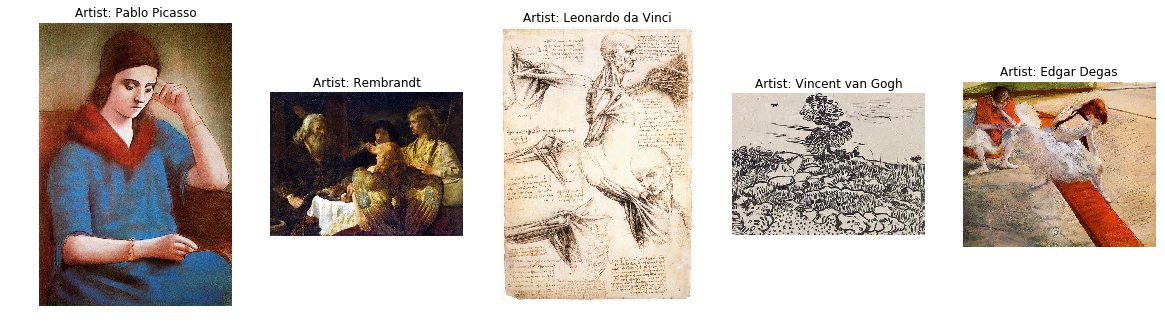

In [8]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

## Data Augmentation

In [9]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 5231 images belonging to 25 classes.
Found 1293 images belonging to 25 classes.
Total number of batches = 326 and 80


### Print a random paintings and it's random augmented version

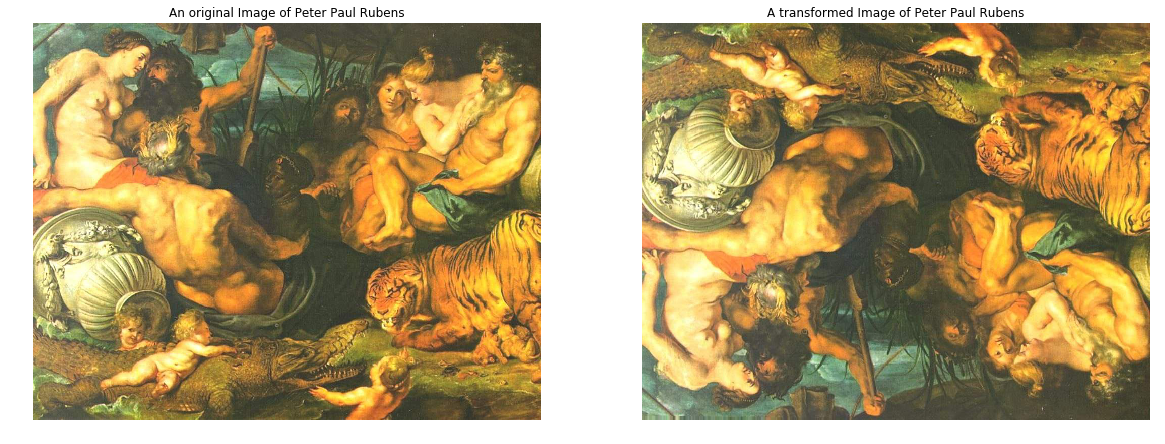

In [10]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## Build Model

In [11]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [12]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [13]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [14]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [15]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr,early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/30
326/326 [==============================] - 180s 552ms/step - loss: 2.6293 - acc: 0.2792 - val_loss: 3.3911 - val_acc: 0.0352
Epoch 2/30
326/326 [==============================] - 173s 532ms/step - loss: 2.1163 - acc: 0.4568 - val_loss: 3.5329 - val_acc: 0.0773
Epoch 3/30
326/326 [==============================] - 178s 545ms/step - loss: 1.9714 - acc: 0.5168 - val_loss: 2.8377 - val_acc: 0.2188
Epoch 4/30
326/326 [==============================] - 175s 538ms/step - loss: 1.7694 - acc: 0.5772 - val_loss: 2.0852 - val_acc: 0.5109
Epoch 5/30
326/326 [==============================] - 174s 533ms/step - loss: 1.6015 - acc: 0.6291 - val_loss: 1.9255 - val_acc: 0.5766
Epoch 6/30
326/326 [==============================] - 176s 540ms/step - loss: 1.4310 - acc: 0.6652 - val_loss: 1.8507 - val_acc: 0.6000
Epoch 7/30
326/326 [==============================] - 177s 543ms/step - loss: 1.2742 - acc: 0.7128 - val_loss: 1.7669 - val_acc: 0.6336
Epoch 8/30
326/326 [============================

In [17]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

327/327 [==============================] - 130s 399ms/step - loss: 0.1717 - acc: 0.9671
Prediction accuracy on train data = 0.9671191


In [18]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on validation data =", score[1])

81/81 [==============================] - 32s 399ms/step - loss: 1.1243 - acc: 0.7208
Prediction accuracy on validation data = 0.72080433


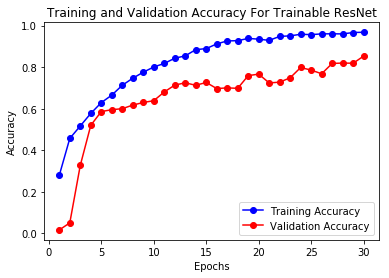

In [56]:
import matplotlib.pyplot as plt

# Access the loss values from the history
training_acc = history1.history['acc']
validation_acc = history1.history['val_acc']

# Plot the training and validation loss
epochs = range(1, len(training_acc) + 1)
plt.plot(epochs, training_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy For Trainable ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



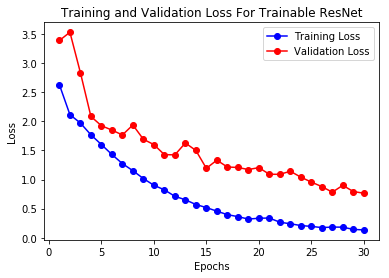

In [79]:
import matplotlib.pyplot as plt

# Access the loss values from the history
training_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss For Trainable ResNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [19]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=32,
                              class_weight=class_weights
                             )

Epoch 1/50
326/326 [==============================] - 171s 525ms/step - loss: 0.7860 - acc: 0.8380 - val_loss: 1.4879 - val_acc: 0.7023
Epoch 2/50
326/326 [==============================] - 171s 523ms/step - loss: 0.7970 - acc: 0.8295 - val_loss: 1.4777 - val_acc: 0.7055
Epoch 3/50
326/326 [==============================] - 172s 528ms/step - loss: 0.7911 - acc: 0.8291 - val_loss: 1.4895 - val_acc: 0.7016
Epoch 4/50
326/326 [==============================] - 174s 532ms/step - loss: 0.7783 - acc: 0.8422 - val_loss: 1.6533 - val_acc: 0.6820
Epoch 5/50
326/326 [==============================] - 171s 525ms/step - loss: 0.7821 - acc: 0.8403 - val_loss: 1.4388 - val_acc: 0.7133
Epoch 6/50
326/326 [==============================] - 171s 525ms/step - loss: 0.7840 - acc: 0.8453 - val_loss: 1.5242 - val_acc: 0.6984
Epoch 7/50
326/326 [==============================] - 171s 525ms/step - loss: 0.7698 - acc: 0.8445 - val_loss: 1.4775 - val_acc: 0.7211
Epoch 8/50
326/326 [============================

## Training graph

In [20]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['acc'] + history2.history['acc']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
history['lr'] = history1.history['lr'] + history2.history['lr']

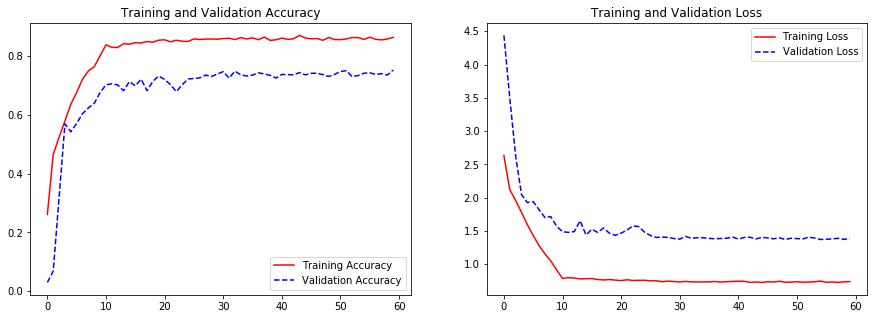

In [23]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

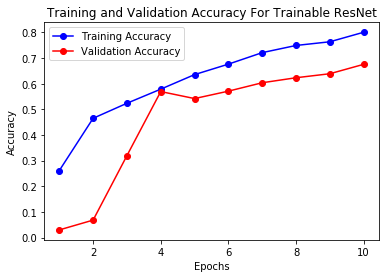

In [25]:
import matplotlib.pyplot as plt

# Access the loss values from the history
training_acc = history1.history['acc']
validation_acc = history1.history['val_acc']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy For Trainable ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




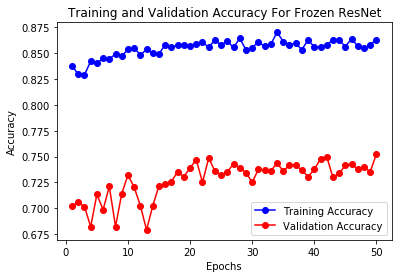

In [28]:
import matplotlib.pyplot as plt

# Access the loss values from the history
training_acc = history2.history['acc']
validation_acc = history2.history['val_acc']

# Plot the training and validation loss
epochs = range(1, len(training_acc) + 1)
plt.plot(epochs, training_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy For Frozen ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





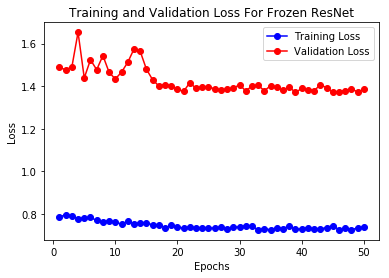

In [29]:
import matplotlib.pyplot as plt

# Access the loss values from the history
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss For Frozen ResNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()






## Evaluate performance

In [21]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

327/327 [==============================] - 158s 482ms/step - loss: 0.7919 - acc: 0.9197
Prediction accuracy on train data = 0.91970944


In [22]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

81/81 [==============================] - 35s 431ms/step - loss: 1.3987 - acc: 0.7285
Prediction accuracy on CV data = 0.7285383


In [24]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

327/327 [==============================] - 131s 402ms/step - loss: 0.7913 - acc: 0.9186
Prediction accuracy on train data = 0.9185624


In [ ]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

## Confusion Matrix. Look at the style of the artists which the model thinks are almost similar. 

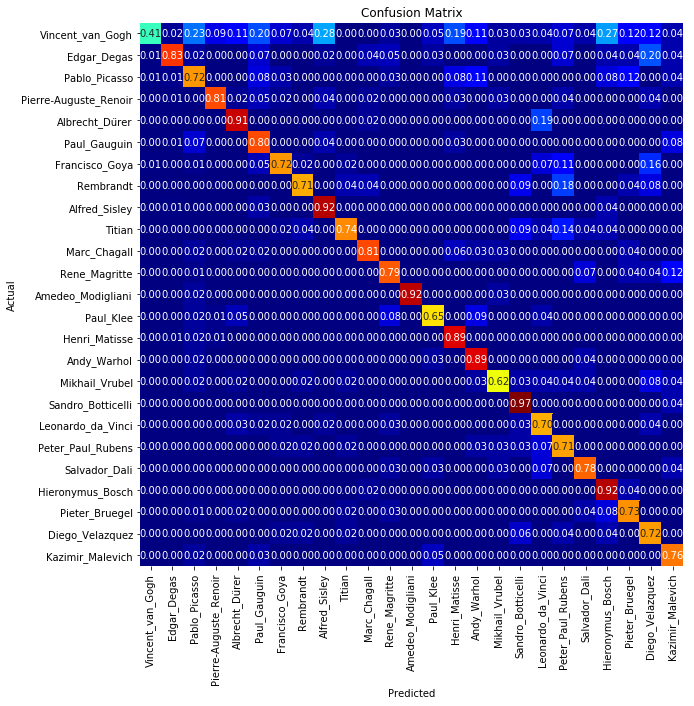

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.96      0.41      0.57       172
          Edgar_Degas       0.93      0.83      0.88       140
        Pablo_Picasso       0.58      0.72      0.65        87
Pierre-Auguste_Renoir       0.87      0.81      0.84        67
      Albrecht_Dürer       0.78      0.91      0.84        64
         Paul_Gauguin       0.60      0.80      0.69        61
       Francisco_Goya       0.79      0.72      0.76        58
            Rembrandt       0.82      0.71      0.76        51
        Alfred_Sisley       0.70      0.92      0.79        50
               Titian       0.84      0.74      0.79        50
         Marc_Chagall       0.84      0.81      0.83        47
        Rene_Magritte       0.75      0.79      0.77        38
    Amedeo_Modigliani       1.00      0.92      0.96        37
            Paul_Klee       0.77      0.65      0.71        37
        Henri_Matisse       0.7

In [30]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)